In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_parquet('yellow_tripdata_2023-01.parquet')
df.info

<bound method DataFrame.info of          VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-01-01 00:32:10   2023-01-01 00:40:36              1.0   
1               2  2023-01-01 00:55:08   2023-01-01 01:01:27              1.0   
2               2  2023-01-01 00:25:04   2023-01-01 00:37:49              1.0   
3               1  2023-01-01 00:03:48   2023-01-01 00:13:25              0.0   
4               2  2023-01-01 00:10:29   2023-01-01 00:21:19              1.0   
...           ...                  ...                   ...              ...   
3066761         2  2023-01-31 23:58:34   2023-02-01 00:12:33              NaN   
3066762         2  2023-01-31 23:31:09   2023-01-31 23:50:36              NaN   
3066763         2  2023-01-31 23:01:05   2023-01-31 23:25:36              NaN   
3066764         2  2023-01-31 23:40:00   2023-01-31 23:53:00              NaN   
3066765         2  2023-01-31 23:07:32   2023-01-31 23:21:56              NaN

In [5]:
initial = len(df)

In [6]:
df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [7]:
df['duration'].std()

42.59435124195458

In [8]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
final = len(df)
print((final/initial)*100)

98.1220282212598


In [10]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train

<3009173x516 sparse matrix of type '<class 'numpy.float64'>'
	with 9027519 stored elements in Compressed Sparse Row format>

In [11]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.658813384236691

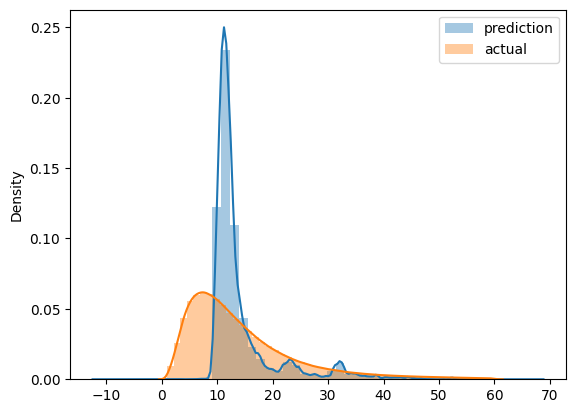

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [36]:
def read_dataframe(filename):
    df1 = pd.read_parquet(filename)

    df1.tpep_dropoff_datetime = pd.to_datetime(df1.tpep_dropoff_datetime)
    df1.tpep_pickup_datetime = pd.to_datetime(df1.tpep_pickup_datetime)
    df1['duration'] = df1.tpep_dropoff_datetime - df1.tpep_pickup_datetime
    df1.duration = df1.duration.apply(lambda td: td.total_seconds() / 60)
    categorical1 = ['PULocationID', 'DOLocationID']

    df1 = df1[(df1.duration >= 1) & (df1.duration <= 60)]
    df1[categorical1] = df1[categorical1].astype(str)
    
    return df1


In [37]:
df1_train = read_dataframe('yellow_tripdata_2023-01.parquet')
df1_val = read_dataframe('yellow_tripdata_2023-02.parquet')

In [38]:
len(df1_train), len(df1_val)

(3009173, 2855951)

In [39]:
df1_train['PU_DO'] = df1_train['PULocationID'] + '_' + df1_train['DOLocationID']
df1_val['PU_DO'] = df1_val['PULocationID'] + '_' + df1_val['DOLocationID']

In [40]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df1_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df1_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [41]:
target = 'duration'
y_train = df1_train[target].values
y_val = df1_val[target].values

In [42]:
print(X_train.shape)
print(X_val.shape)

(3009173, 21802)
(2855951, 21802)


In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.256227422749583

In [20]:
with open('in_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

NameError: name 'pickle' is not defined

In [ ]:
lr = Lasso(0.0001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)